In [27]:
import numpy as np

from Model.Model import *
from Model.config import DEFAULT_PASSER, TM_NGS, TM_NNP

from Encode.Helper_Functions import preprocess, rs_decode, dna_to_int_array, load_dna
from Encode.DNAFountain import DNAFountain, Glass
from Analysis.Analysis import inspect_distribution, examine_strand, save_simu_result, dna_chunk
from Fountain_analyzer import error_profile

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio

import warnings
warnings.simplefilter("ignore")

pio.templates.default = "plotly_white"
pio.renderers.default = 'notebook'
plt.style.use(['science','no-latex'])
plt.rcParams['savefig.dpi'] = 300 
plt.rcParams['figure.dpi'] = 300
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load Data

In [2]:
# load dna
in_dnas = load_dna('files/lena.dna')
arg = DEFAULT_PASSER

# Step-by-step simulation

## Synthesis

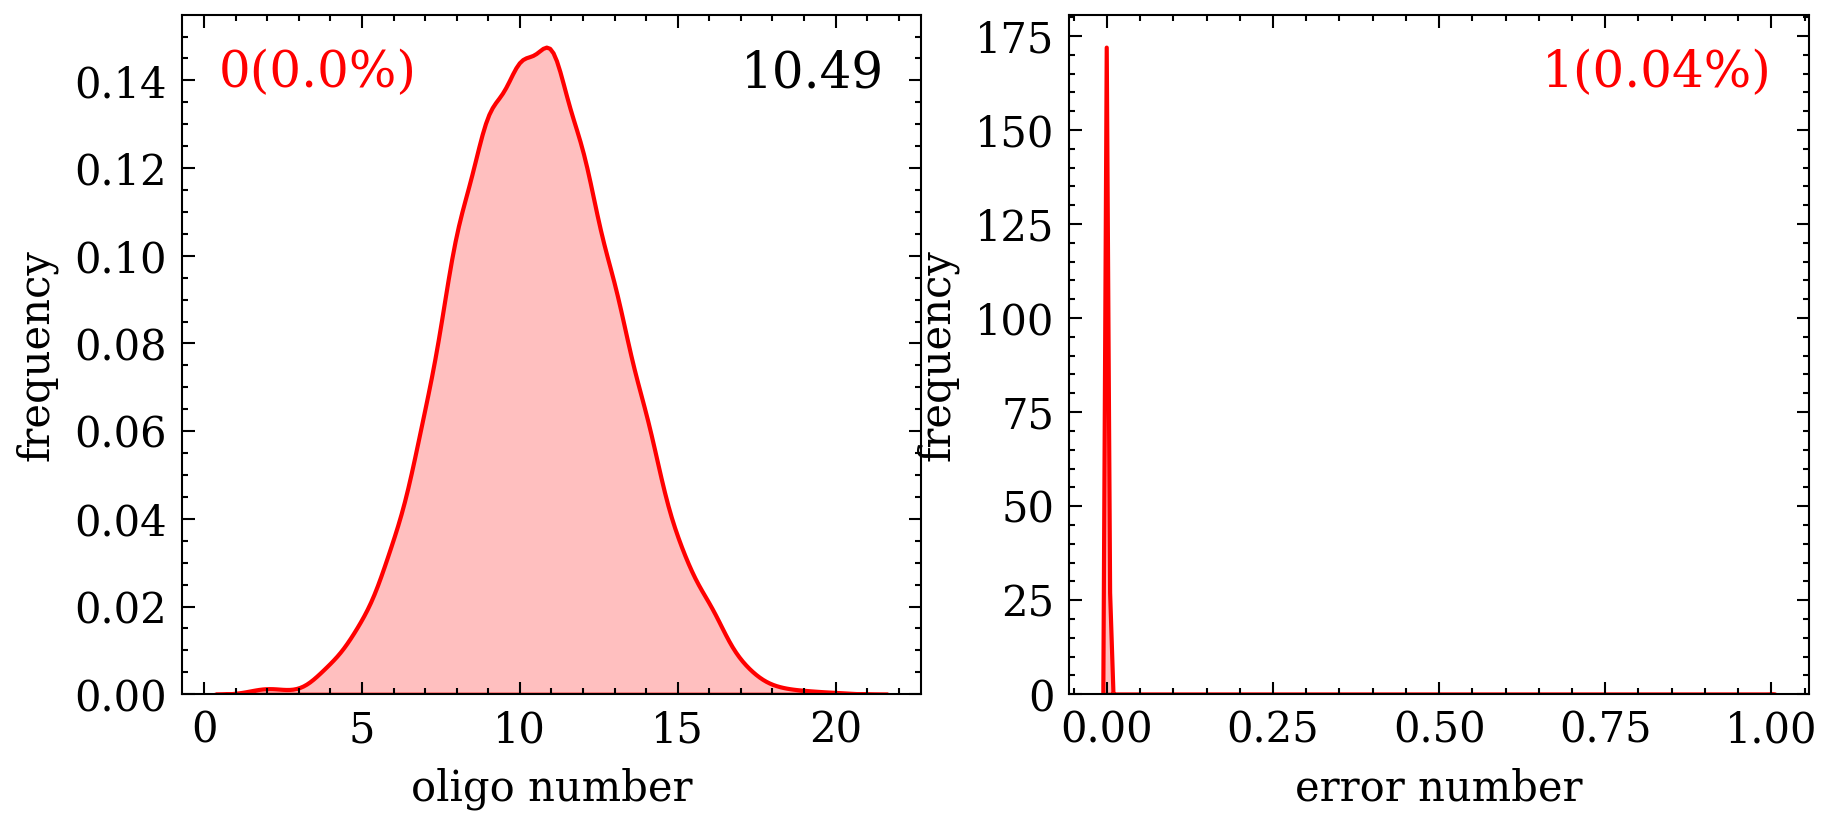

+----------+-----------------------------------------------+
| read num |                     re_dna                    |
+----------+-----------------------------------------------+
|    3     |                                               |
|    1     |                                    C          |
|    1     |                         C                     |
|    1     |                                    C          |
|    1     |                                            T  |
|    1     |                              A              G |
|    1     |                          T                    |
+----------+-----------------------------------------------+


In [19]:
index = 1
SYN = Synthesizer(arg)
dnas_syn = SYN(in_dnas)
inspect_distribution(dnas_syn, show = True)
examine_strand(dnas_syn, index = index)

## Decay

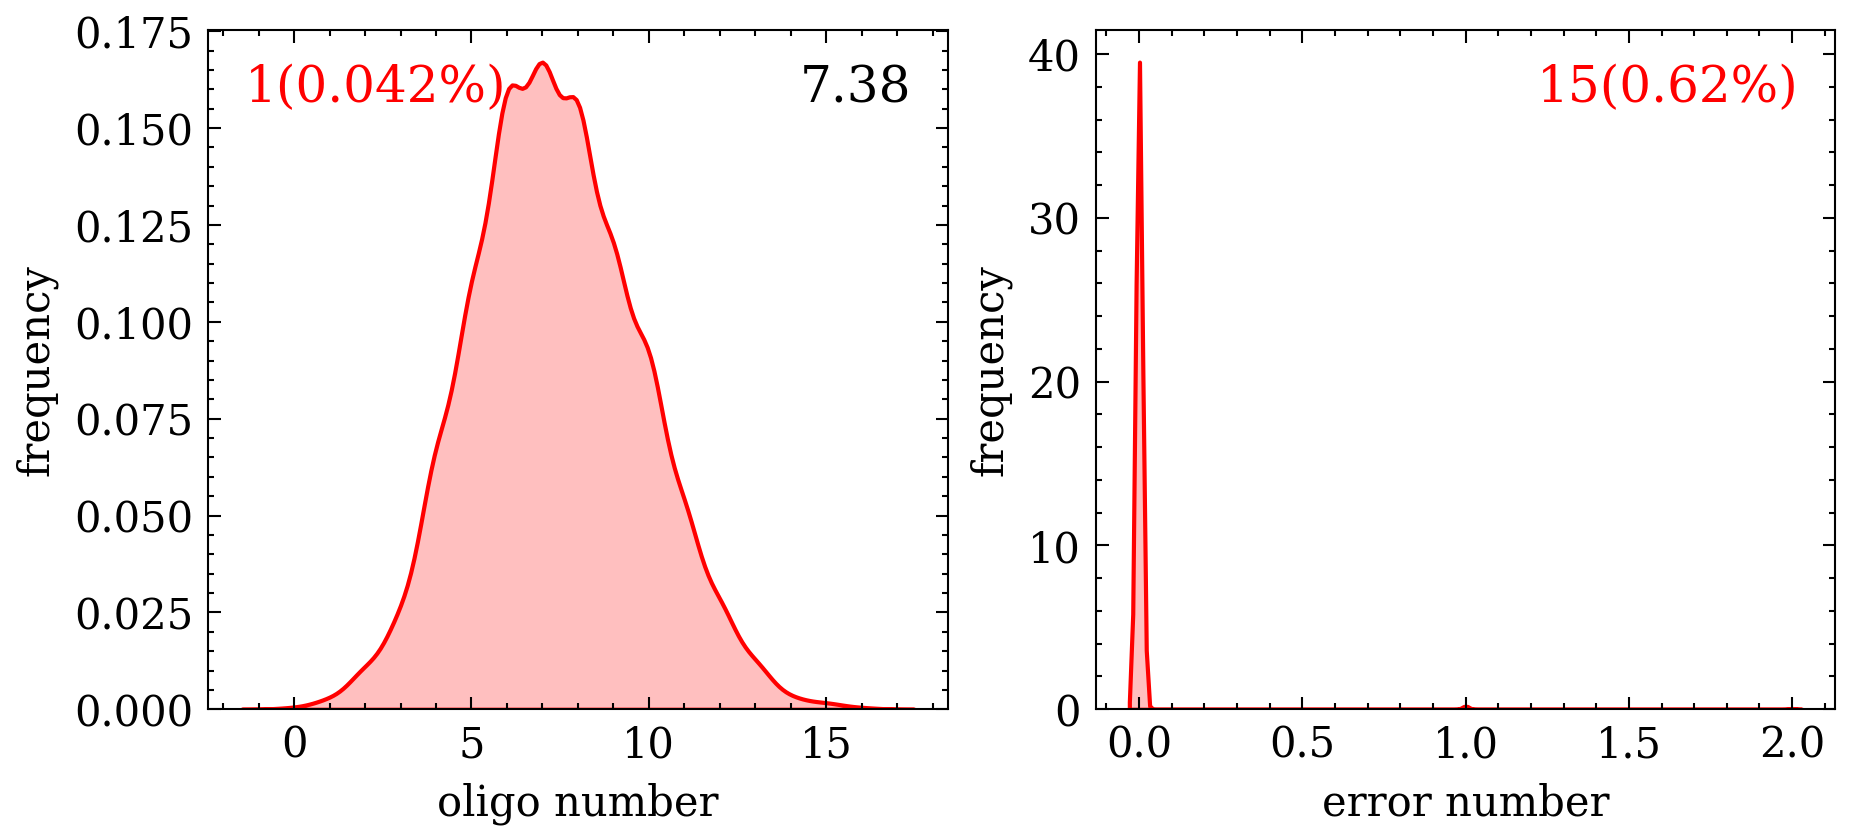

+----------+----------------------------+
| read num |           re_dna           |
+----------+----------------------------+
|    1     |                            |
|    1     |                          C |
|    1     |                          C |
+----------+----------------------------+


In [20]:
DEC = Decayer(arg)
dnas_dec = DEC(dnas_syn)

inspect_distribution(dnas_dec, show = True)
examine_strand(dnas_dec, index = index)

## PCR

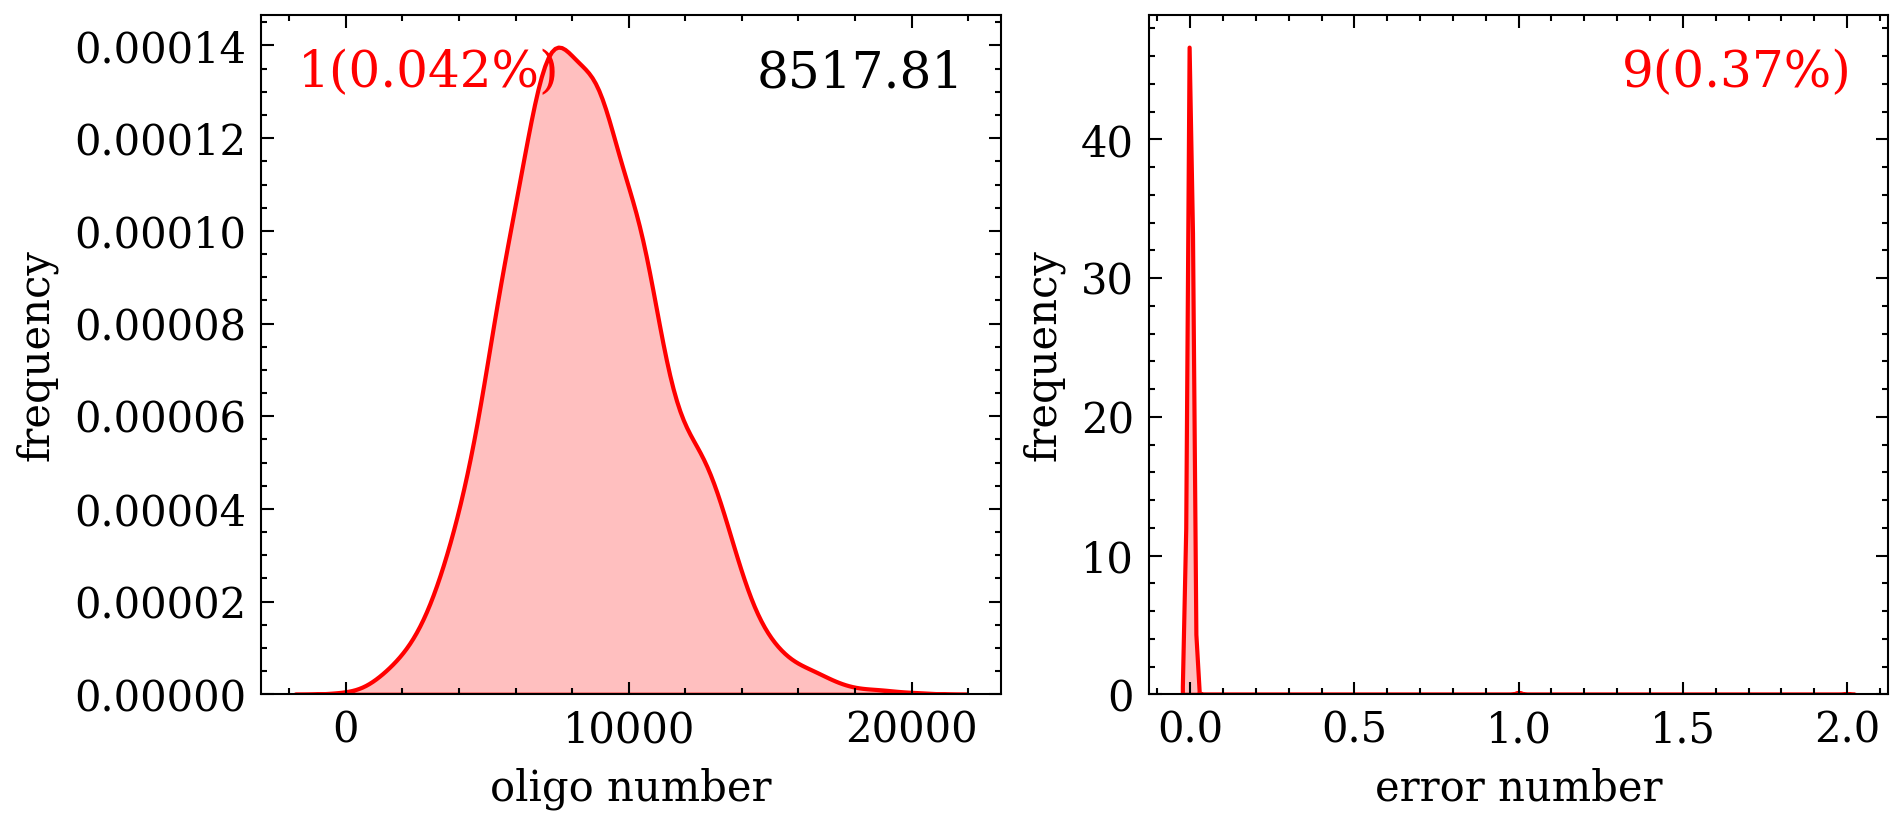

+----------+----------------------------+
| read num |           re_dna           |
+----------+----------------------------+
|   1003   |                            |
|   1195   |                          C |
|   1676   |                          C |
+----------+----------------------------+


In [22]:
PCR = PCRer(N = 12, p = 0.8)
dnas_pcr = PCR(dnas_dec)

inspect_distribution(dnas_pcr, show = True)
examine_strand(dnas_pcr, index = index)

## Sampling

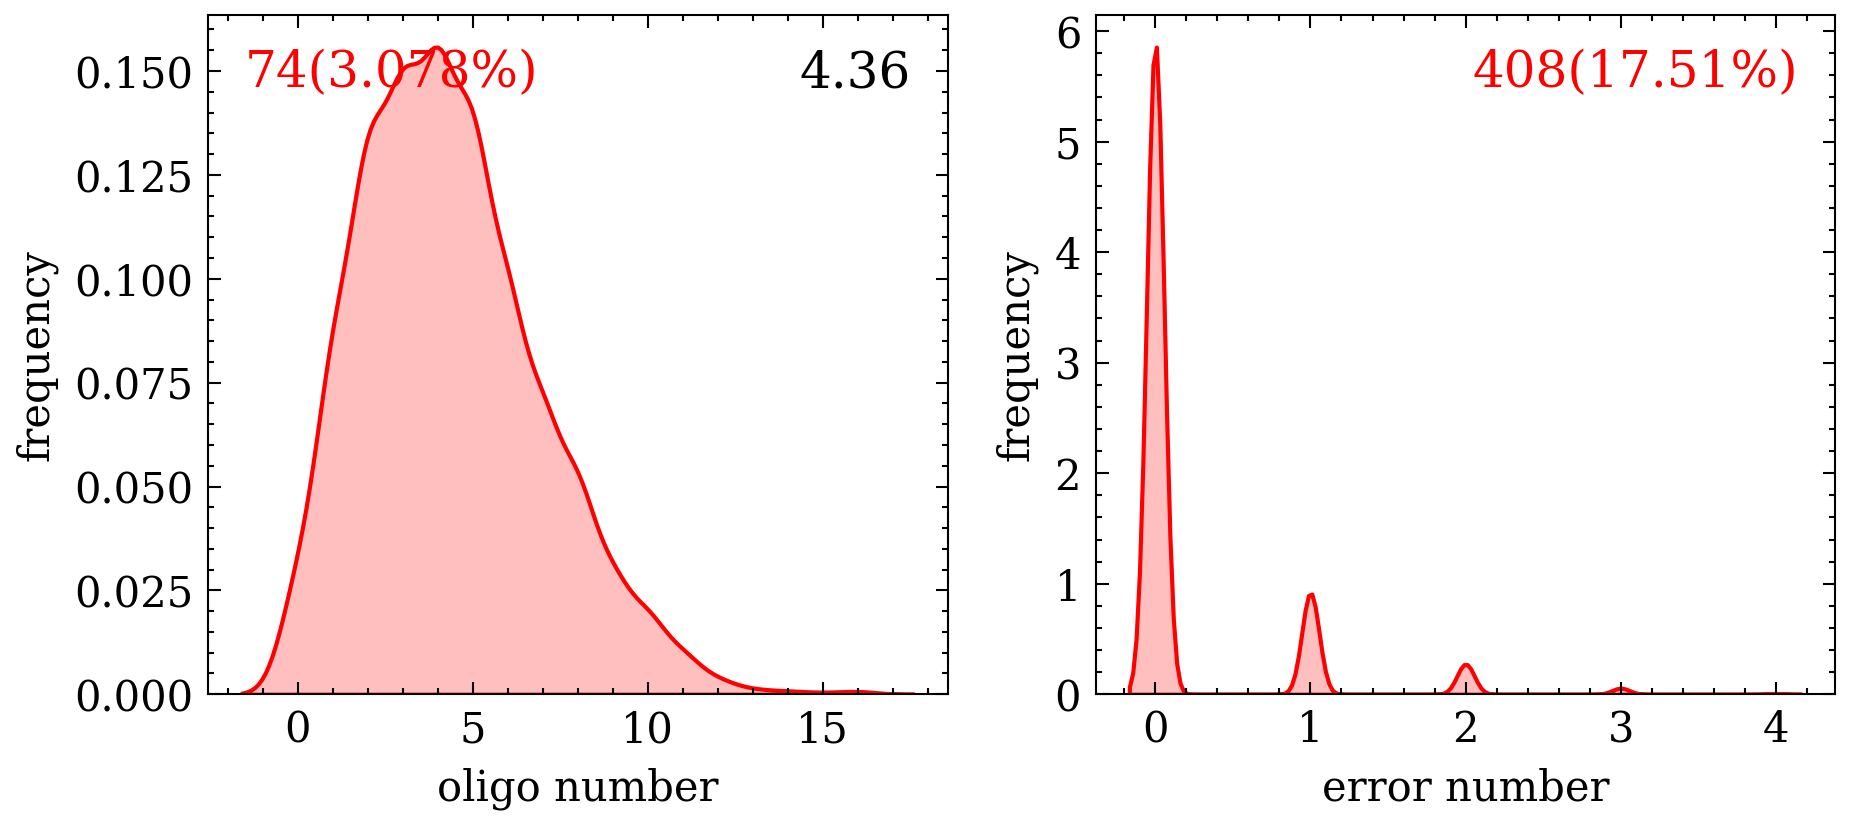

+----------+--------+
| read num | re_dna |
+----------+--------+
|    1     |        |
+----------+--------+


In [23]:
SAM = Sampler(0.0005)
dnas_sam = SAM(dnas_pcr)

inspect_distribution(dnas_sam, show = True)
examine_strand(dnas_sam, index = index)

## Sequencing

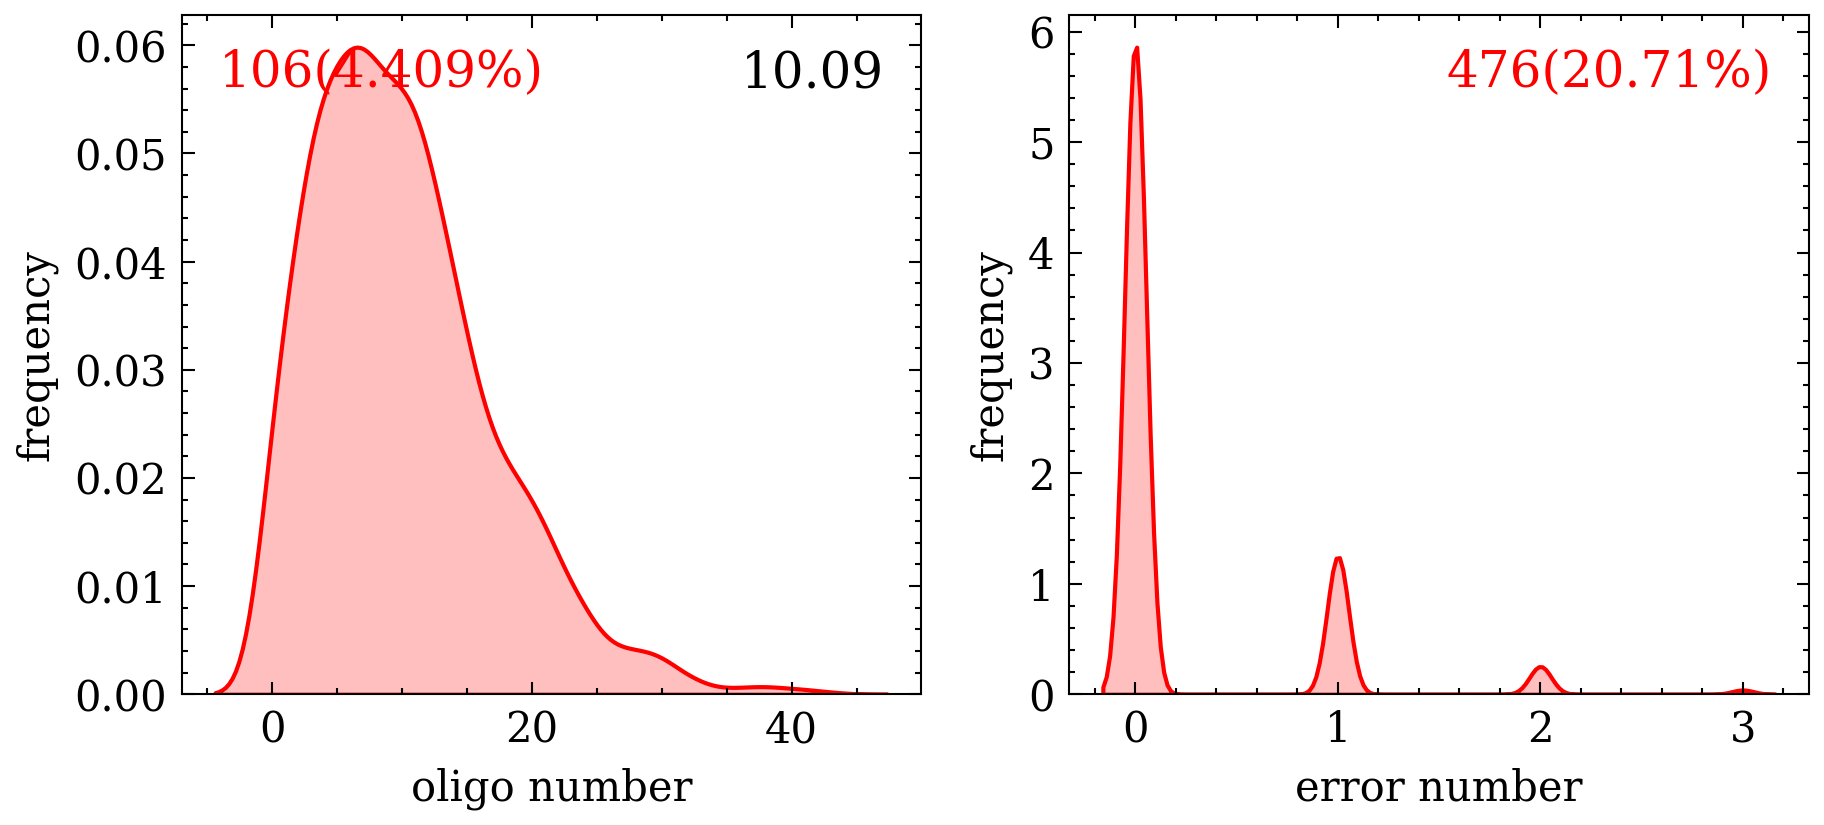

+----------+--------+
| read num | re_dna |
+----------+--------+
|    4     |        |
+----------+--------+


In [24]:
SEQ = Sequencer(arg)
dnas_seq = SEQ(dnas_sam)

inspect_distribution(dnas_seq, show = True)
examine_strand(dnas_seq, index = index)

# Inspect influence of parameters to final error rate

In [26]:
conditions = [[0.01,TM_NGS],[0.01,TM_NNP]]
Seq_depths = [5,10,20,40,70,100]

R = []
arg = DEFAULT_PASSER
for condition in conditions:
    Rc = []
    for seq_depth in Seq_depths:
        Rp = []
        for i in range(5):
            arg.sam_ratio = condition[0]
            arg.seq_TM = condition[1]
            arg.seq_depth = seq_depth
            Model = DNA_Channel_Model(None,arg)
            out_dnas = Model(in_dnas,print_state = False)
            lost_num, error_num = inspect_distribution(out_dnas, show = False)
            Rp.append([lost_num, error_num])
        Rc.append(Rp)
    R.append(Rc)

In [ ]:
R = 

In [262]:
def plot_error_bar(x,y,label):
    y_mean = np.mean(y, axis = 1)
    y_max = np.max(y,axis = 1)
    y_min = np.min(y,axis = 1)
    y_err = [y_max - y_mean, y_mean - y_min]
    plt.errorbar(x,y_mean,y_err,label = label, fmt = '-o', markersize = 1)

Text(0, 0.5, 'Number of oligos with error')

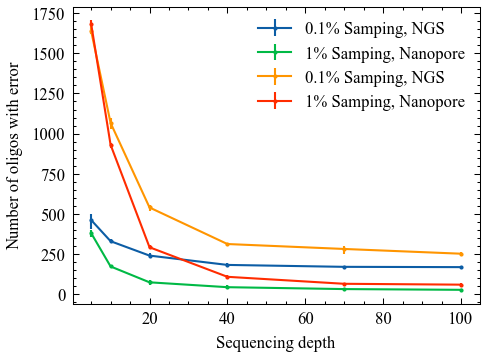

In [263]:
plot_error_bar(Seq_depths, R1[0,:,:,1],'0.1% Samping, NGS')
plot_error_bar(Seq_depths, R[0,:,:,1],'1% Samping, Nanopore')
plot_error_bar(Seq_depths, R1[2,:,:,1],'0.1% Samping, NGS')
plot_error_bar(Seq_depths, R[1,:,:,1],'1% Samping, Nanopore')
plt.legend()
plt.xlabel('Sequencing depth')
plt.ylabel('Number of oligos with error')

Text(0, 0.5, 'Number of lost oligos')

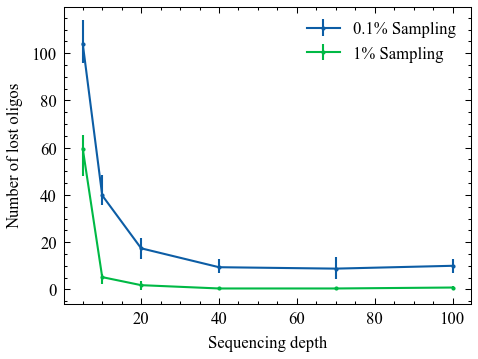

In [264]:
plot_error_bar(Seq_depths, R1[0,:,:,0],'0.1% Sampling')
plot_error_bar(Seq_depths, R[0,:,:,0],'1% Sampling')
# plot_error_bar(Seq_depths, R1[2,:,:,1],'0.1%, NGS')
# plot_error_bar(Seq_depths, R[1,:,:,1],'1%, Nanopore')
plt.legend()
plt.xlabel('Sequencing depth')
plt.ylabel('Number of lost oligos')